In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)

from scipy.stats import norm

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Dropout, Reshape
from tensorflow.keras.optimizers import Adam

C:\Users\asa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('powerconsumption.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [3]:
dataset = df[['Datetime', 'PowerConsumption_Zone1']]

In [4]:
def create_sequences(data, window_size):
    sequences = []
    for i in range(int(len(data)/window_size)):
        sequence = data[i*window_size:i*window_size+window_size]
        sequences.append(sequence)
    return np.array(sequences)

window_size = 144  
sequences = create_sequences(dataset['PowerConsumption_Zone1'].values, window_size)

print(sequences.shape) 
print(sequences)

(364, 144)
[[34055.6962  29814.68354 29128.10127 ... 29681.01266 28830.37975
  27748.86076]
 [26703.79747 26169.11392 25622.27848 ... 29346.83544 28593.41772
  27779.24051]
 [26661.26582 26150.88608 25433.92405 ... 30063.79747 29298.22785
  28550.88608]
 ...
 [26938.40304 26609.88593 25892.01521 ... 29505.70342 28909.5057
  28167.30038]
 [27266.92015 27023.57414 26390.87452 ... 30333.07985 29067.68061
  28544.48669]
 [27692.77567 26792.39544 26098.85932 ... 29590.87452 28958.1749
  28349.80989]]


In [5]:
time_series_data = np.expand_dims(sequences, axis=-1) 

In [6]:
encoder_input = layers.Input(shape=(144, 1), name='e_input')
x = layers.Conv1D(filters=32, kernel_size=3,padding='same', activation = 'relu')(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(filters=64, kernel_size=3,padding='same', activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv1D(filters=128, kernel_size=3,padding='same', activation = 'relu')(x)

shape_before_flattening = K.int_shape(x)[1:] # shape of the tensor

x = layers.Flatten()(x)
"""z_mean = layers.Dense(2, name='z_mean')(x)
z_log_var = layers.Dense(2, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])"""
latent = layers.Dense(16, name='latent_space')(x)
#encoder = models.Model(encoder_input,[z_mean,z_log_var,z], name = 'encoder')
encoder = models.Model(encoder_input, latent, name='encoder')
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ e_input (InputLayer)                 │ (None, 144, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 144, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 144, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 144, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 144, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 144, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 16)                  │         294,928 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 326,352 (1.24 MB)

 Trainable params: 326,160 (1.24 MB)

 Non-trainable params: 192 (768.00 B)

In [7]:
decoder_input = layers.Input(shape=(16,), name='d_input')
x = layers.Dense(np.prod(shape_before_flattening) )(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv1DTranspose(filters=128, kernel_size=3,padding='same', activation = 'relu')(x)
x = layers.Conv1DTranspose(filters=64, kernel_size=3,padding='same', activation = 'relu')(x)
x = layers.Conv1DTranspose(filters=32, kernel_size=3,padding='same', activation = 'relu')(x)
decoder_output = layers.Conv1D(filters=1, kernel_size=3, padding='same',activation = 'sigmoid',name='d_output')(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ d_input (InputLayer)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 18432)               │         313,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 144, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 144, 128)            │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 144, 64)             │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, 144, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ d_output (Conv1D)                    │ (None, 144, 1)              │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 393,537 (1.50 MB)

 Trainable params: 393,537 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
autoencoder_input = encoder_input
autoencoder_output = decoder(encoder(autoencoder_input))

autoencoder = models.Model(autoencoder_input, autoencoder_output, name='autoencoder')
autoencoder.summary()


autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse')

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ e_input (InputLayer)                 │ (None, 144, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 16)                  │         326,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 144, 1)              │         393,537 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 719,889 (2.75 MB)

 Trainable params: 719,697 (2.75 MB)

 Non-trainable params: 192 (768.00 B)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
time_series_data.shape

(364, 144, 1)

In [11]:
X_train, X_val = train_test_split(time_series_data, test_size=0.2, random_state=42)

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Flatten, scale, and reshape the data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

In [13]:
# Train the autoencoder
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,  
    epochs=25,         
    batch_size=8,     
    validation_data=(X_val_scaled, X_val_scaled),  
    shuffle=True       
)


Epoch 1/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0236 - val_loss: 0.0320
Epoch 2/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059 - val_loss: 0.0297
Epoch 3/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0031 - val_loss: 0.0275
Epoch 4/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - val_loss: 0.0263
Epoch 5/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017 - val_loss: 0.0245
Epoch 6/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 0.0226
Epoch 7/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0015 - val_loss: 0.0208
Epoch 8/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0013 - val_loss: 0.0198
Epoch 9/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0017 - val_loss: 0.0170
Epoch 10/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012 - val_loss: 0.0138
Epoch 11/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.6941e-04 - val_loss: 0.0123
Epoch 12/25
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss:

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


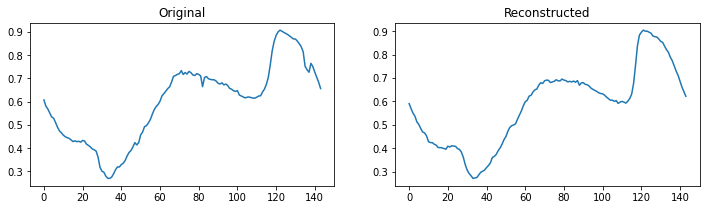

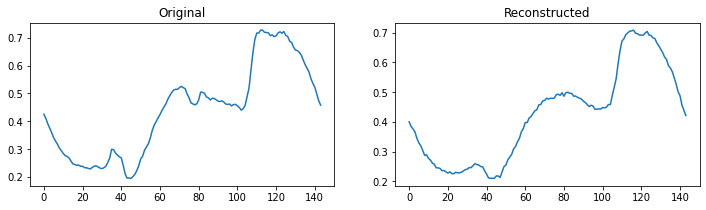

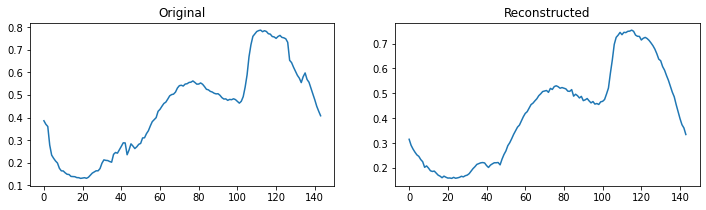

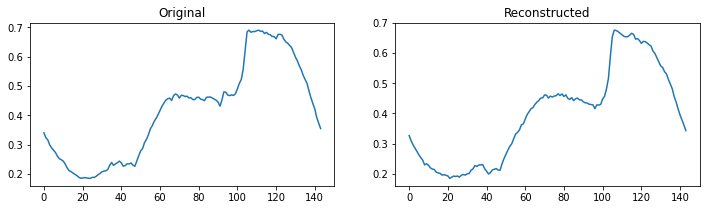

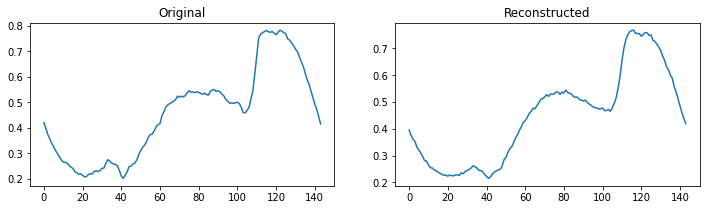

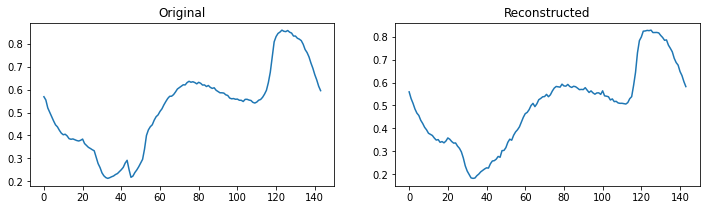

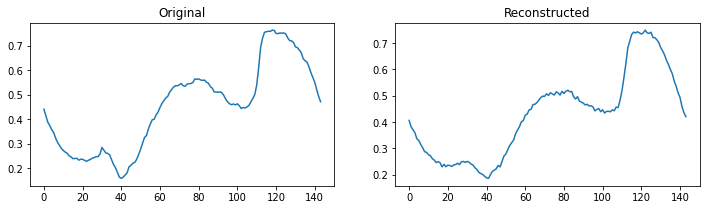

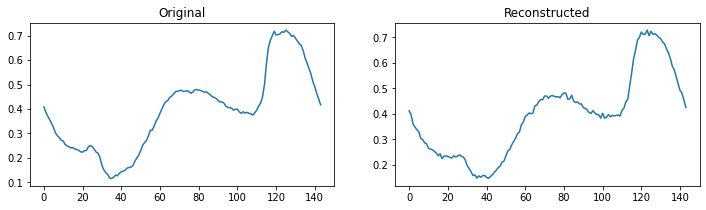

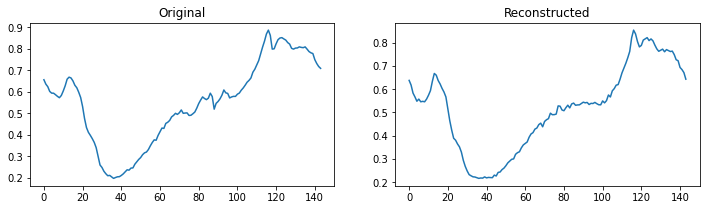

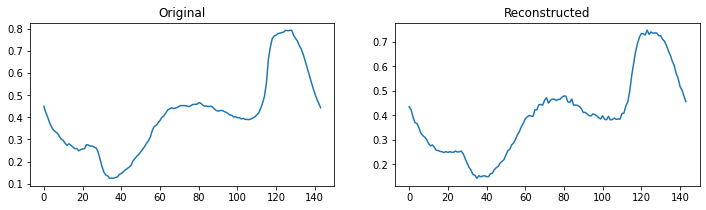

In [15]:
decoded_data = autoencoder.predict(X_val_scaled)


import matplotlib.pyplot as plt

for i in range(10):  
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(X_val_scaled[i].reshape(-1), label="Original")
    plt.title("Original")
    
    plt.subplot(1, 2, 2)
    plt.plot(decoded_data[i].reshape(-1), label="Reconstructed")
    plt.title("Reconstructed")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


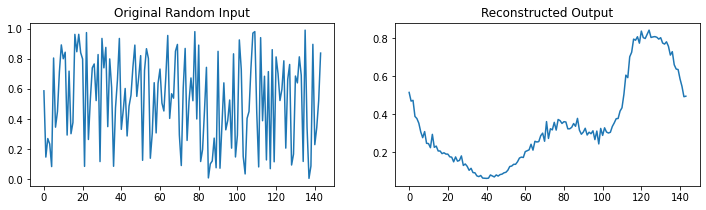

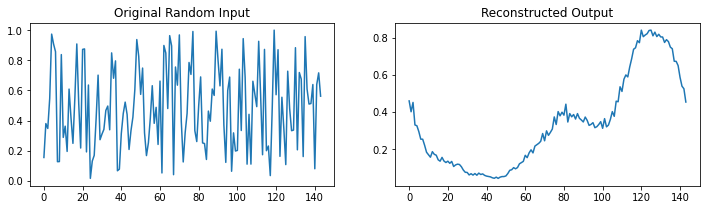

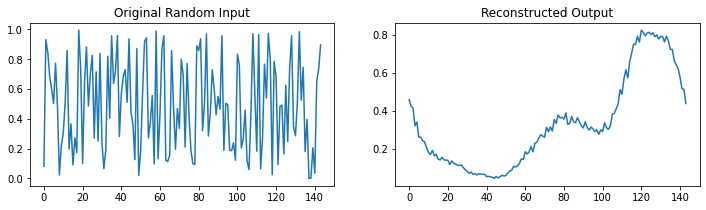

In [16]:

random_input = np.random.rand(3, 144, 1)  

decoded_data = autoencoder.predict(random_input)

for i in range(3):  
    plt.figure(figsize=(12, 3))
    
    # Plot original random input
    plt.subplot(1, 2, 1)
    plt.plot(random_input[i].reshape(-1), label="Original Random")
    plt.title("Original Random Input")
    
    # Plot reconstructed output
    plt.subplot(1, 2, 2)
    plt.plot(decoded_data[i].reshape(-1), label="Reconstructed")
    plt.title("Reconstructed Output")
    
    plt.show()
